<a href="https://colab.research.google.com/github/AmDeep/AI_LaunchLab_Team3/blob/main/SR_SM_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install netcdf4

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls drive/MyDrive/Colab\ Notebooks/Climate/Data/SR

cropped_x.pt  output_file_baseline.nc  super_resolution_sample.nc
cropped_y.pt  super_resolution.nc


In [51]:
DATA_LOC = 'drive/MyDrive/Colab Notebooks/Climate/Data/SR'

In [52]:
import xarray as xa

INPUT_FILE = DATA_LOC + '/' + 'super_resolution_sample.nc'

In [53]:
sample_x = xa.open_dataset(INPUT_FILE, group='/train/x')

In [54]:
df = sample_x.to_dataframe()

In [55]:
df.columns

Index(['mg_delta', 'me_delta', 'zp_delta', 'vg_delta', 'td', 'tt', 'pn', 'nt',
       'h', 'rt', 'i4', '5p', 'i6', 'uu', 'vv'],
      dtype='object')

In [56]:
sample_y = xa.open_dataset(INPUT_FILE, group='/train/y')

In [57]:
df_y = sample_y.to_dataframe()

In [58]:
df.shape

(1310720, 15)

In [59]:
df_y.columns

Index(['tt'], dtype='object')

In [60]:
df.head()

mg_delta    me_delta  ...        uu        vv
time       x y                            ...                    
2016-10-01 0 0  5.995204e-14  -73.769531  ...  1.102224  1.666101
             1  5.995204e-14  -22.457031  ...  1.102224  1.666101
             2  5.995204e-14    1.855469  ...  1.102224  1.666101
             3  5.995204e-14  -71.894531  ... -0.372873  1.744226
             4  5.995204e-14 -104.457031  ... -0.372873  1.744226

[5 rows x 15 columns]

In [61]:
from sklearn.model_selection import train_test_split

#Without standardscaler RMSE values were slightly worse but feature importances didn't align with what was expected
#X_train, X_test, y_train, y_test = train_test_split(df, df_y, test_size=0.20)

In [62]:
from sklearn.preprocessing import StandardScaler

sdf = StandardScaler().fit_transform(df)

In [64]:
import pandas as pd

ssdf=pd.DataFrame(sdf,columns=df.columns)

In [69]:
from sklearn import linear_model

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(ssdf, df_y, test_size=0.20)
lm = linear_model.LinearRegression()
model = lm.fit(X_train_s,y_train_s)

In [70]:
predictions = lm.predict(X_test_s)

In [71]:
lm.score(X_test_s,y_test_s)

0.8445830393127643

In [72]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_test_s, predictions, squared=False)

In [73]:
rms

1.7821016

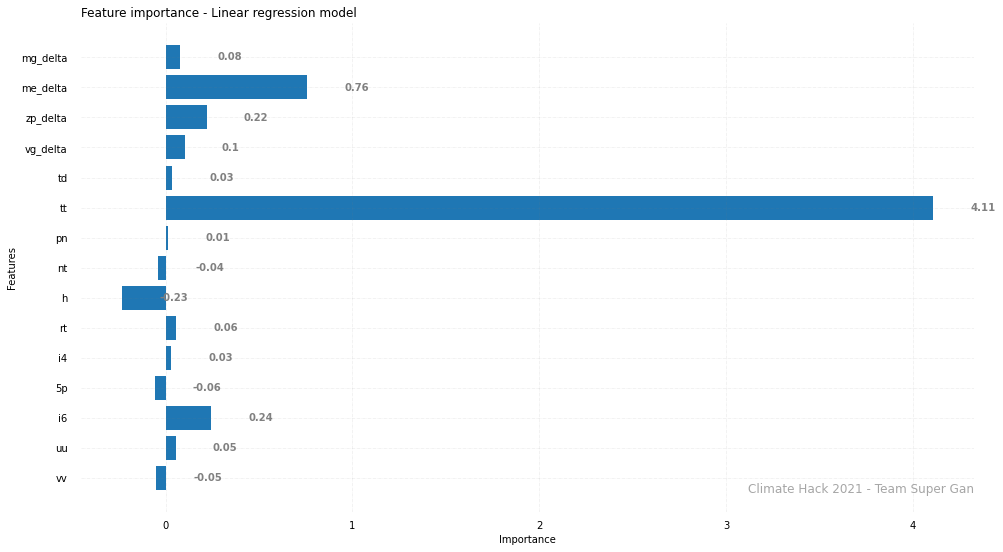

In [79]:
from matplotlib import pyplot as plt

importance = lm.coef_[0]

# plot feature importance
fig, ax = plt.subplots(figsize =(16, 9)) 
  
# Horizontal Bar Plot 
ax.barh([x for x in df.columns], importance)
  
# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 
  
# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 
  
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2) 
  
# Show top values  
ax.invert_yaxis() 
  
# Add annotation to bars 
for i in ax.patches: 
    plt.text(i.get_width()+0.2, i.get_y()+0.5,  
             str(round((i.get_width()), 2)), 
             fontsize = 10, fontweight ='bold', 
             color ='grey') 
  
# Add Plot Title 
ax.set_title('Feature importance - Linear regression model', 
             loc ='left', ) 
  
# Add Text watermark 
fig.text(0.9, 0.15, 'Climate Hack 2021 - Team Super Gan', fontsize = 12, 
         color ='grey', ha ='right', va ='bottom', 
         alpha = 0.7) 

plt.xlabel('Importance')
plt.ylabel('Features')

# Show Plot 
plt.show() 

In [75]:
from sklearn.linear_model import ElasticNetCV

regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(X_train_s, y_train_s)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [43]:
regr.alpha_

1.1120848388671876

In [44]:
regr.intercept_

1.3956766

In [77]:
y_pred_en_s = regr.predict(X_test_s)
rms_en_s = mean_squared_error(y_test_s, y_pred_en_s, squared=False)

In [78]:
rms_en_s

1.7823838